# STIRAP

This example calculates the basic STIRAP effect.  It demonstrates how to modulate the intensity of a laser with time in `pylcp` to get an interesting physical effect.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pylcp

### Define the problem

This is the same as in the [last example](07_three_level_susceptibility.ipynb) in setting up the three state system, except here we add a temporal Gaussian modulation to the intensity of the laser beam.  Most STIRAP literature uses $\Omega$ rather than $I$, so remember that $I/I_{\rm sat} = 2\Omega^2/\Gamma^2$.

In [2]:
# First, define the lasers (functionalized for later):
def return_three_level_lasers(Omegage, Omegare, t0, tsep, twid):
    laserBeams = {}
    laserBeams['g->e'] = pylcp.laserBeams(
        [{'kvec':np.array([1., 0., 0.]), 'pol':np.array([0., 1., 0.]),
          'pol_coord':'spherical', 'delta':0., 's':lambda R, t: 2*(Omegage*np.exp(-(t-t0-tsep/2)**2/2/twid**2))**2}],
    )
    laserBeams['r->e'] = pylcp.laserBeams(
        [{'kvec':np.array([1., 0., 0.]), 'pol':np.array([0., 1., 0.]),
          'pol_coord':'spherical', 'delta':0., 's':lambda R, t: 2*(Omegare*np.exp(-(t-t0+tsep/2)**2/2/twid**2))**2}],                           
    )
    return laserBeams

# Second, magnetic field:
magField = lambda R: np.zeros(R.shape)

# Now define the Hamiltonian (functionaized for later):
H0 = np.array([[1.]])
mu_q = np.zeros((3, 1, 1))
d_q = np.zeros((3, 1, 1))
d_q[1, 0, 0,] = 1/np.sqrt(2)

def return_three_level_hamiltonian(Delta, delta):
    hamiltonian = pylcp.hamiltonian()
    hamiltonian.add_H_0_block('g', 0.*H0)
    hamiltonian.add_H_0_block('r', delta*H0)
    hamiltonian.add_H_0_block('e', Delta*H0)
    hamiltonian.add_d_q_block('g','e', d_q)
    hamiltonian.add_d_q_block('r','e', d_q)

    return hamiltonian

### Evolve the density

Let us evolve with the correct pulse order (address $r\rightarrow e$ before $g\rightarrow e$) and also the incorrect, opposite order.  For simplicity, we choose a saturation parameter of 2 to get a $\Omega=\Gamma$ at the peak.

In [3]:
hamiltonian = return_three_level_hamiltonian(-3, 0)
laserBeams = return_three_level_lasers(1, 1, 500, -125., 100)

obe = pylcp.obe(laserBeams, magField, hamiltonian)
obe.set_initial_rho_from_populations(np.array([1., 0., 0.]))
sol1 = obe.evolve_density([0, 1000], progress_bar=True)

laserBeams = return_three_level_lasers(1, 1, 500., 125., 100.)

obe = pylcp.obe(laserBeams, magField, hamiltonian)
obe.set_initial_rho_from_populations(np.array([1., 0., 0.]))
sol2 = obe.evolve_density([0, 1000], progress_bar=True)

Completed in 1.42 s.                                               
Completed in 1.10 s.                                               


Plot up the state populations $\rho_{gg}$ (blue), $\rho_{rr}$ (orange), and $\rho_{ee}$ (green) vs. time.  We see that STIRAP is only effective in the correct order (solid), and it maintains a minium of population in $|e\rangle>$.  The incorrect order (dashed) is nearly completely ineffective at state transfer.  

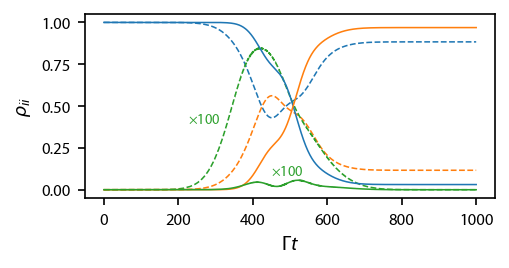

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(3.25, 1.625))
factors = [1, 1, 1e2]
[ax.plot(sol1.t, factor*np.real(sol1.rho[ii, ii]), '--', color='C%d'%ii, linewidth=0.75) for ii, factor in enumerate(factors)]
[ax.plot(sol2.t, factor*np.real(sol2.rho[ii, ii]), '-', color='C%d'%ii, linewidth=0.75) for ii, factor in enumerate(factors)]
ax.set_ylabel('$\\rho_{ii}$')
ax.set_xlabel('$\Gamma t$')
ax.text(225,0.4,'$\\times100$',fontsize=7, color='C2')
ax.text(450,0.085,'$\\times100$',fontsize=7, color='C2')
fig.subplots_adjust(bottom=0.225, left=0.14)